<a href="https://colab.research.google.com/github/LoQiseaking69/SephsBIOME/blob/master/Docs/Model/Tests/Utils/notebooks/SynthDGenV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Dataset Generation for NLP and Robotic Kinematics

This notebook generates a synthetic dataset optimized for combined NLP and robotic kinematics tasks in a reinforcement learning model. The dataset includes both textual and sensor data, with feature engineering applied to enhance its suitability for machine learning tasks.

In [1]:
%%capture
!pip install markovify

## NLP Data Generation Using Brown Corpus

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import nltk
from nltk.corpus import brown
import markovify
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download the 'brown' corpus from nltk
nltk.download('brown')

# Save the brown corpus to a CSV file
def save_brown_corpus(file_path):
    try:
        # Extracting sentences from the brown corpus
        brown_sentences = [' '.join(words) for words in brown.sents()]
        # Converting to DataFrame
        df = pd.DataFrame(brown_sentences, columns=['sentence'])
        # Saving to CSV
        df.to_csv(file_path, index=False)
        return "File saved successfully."
    except Exception as e:
        return f"Error saving file: {e}"

# Example usage
file_save_status = save_brown_corpus('brown_corpus.csv')
print(file_save_status)

# Function to read a CSV file
def read_csv_file(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return "File not found."

# Example usage
csv_data = read_csv_file('brown_corpus.csv')
print(csv_data)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


File saved successfully.
                                                sentence
0      The Fulton County Grand Jury said Friday an in...
1      The jury further said in term-end presentments...
2      The September-October term jury had been charg...
3      `` Only a relative handful of such reports was...
4      The jury said it did find that many of Georgia...
...                                                  ...
57335                                     S. J. Perelman
57336                            revulsion in the desert
57337  the doors of the D train slid shut , and as I ...
57338  She was a living doll and no mistake -- the bl...
57339  From what I was able to gauge in a swift , gre...

[57340 rows x 1 columns]


In [3]:
# Generate text data using Markov chains built from the Brown corpus
text = ' '.join(brown.words())
text_model = markovify.Text(text)

def generate_text_data(num_samples):
    return [text_model.make_short_sentence(100) for _ in range(num_samples)]


## Synthetic Dataset Generation Function

In [4]:
# Function to generate text data from the brown corpus
def generate_text_data(num_samples):
    # Extracting sentences from the brown corpus
    brown_sentences = [' '.join(words) for words in brown.sents()]
    # Randomly selecting sentences to match the number of samples
    random_sentences = random.choices(brown_sentences, k=num_samples)
    return random_sentences

# Function to generate synthetic dataset
def generate_synthetic_dataset(num_samples=1000, num_sensors=128, num_actions=10, noise_level=0.05):
    timestamps = [datetime.now() + timedelta(seconds=i) for i in range(num_samples)]
    text_data = generate_text_data(num_samples)
    sensor_data = {}
    for i in range(num_sensors):
        period = np.random.randint(10, 100)
        sensor_data[f'sensor_{i}'] = np.sin(np.linspace(0, 2 * np.pi * period, num_samples)) + np.random.normal(0, noise_level, num_samples)
    action_data = np.random.randint(0, num_actions, num_samples)
    reward_data = np.random.uniform(-1, 1, num_samples)
    return pd.DataFrame({
        'timestamp': timestamps,
        'text_data': text_data,
        **sensor_data,
        'action': action_data,
        'reward': reward_data
    })

# Generate the dataset
synthetic_dataset = generate_synthetic_dataset()

# Save the dataset to a CSV file
synthetic_dataset.to_csv('SephsDataV3.csv', index=False)

# Inform that the file has been saved
print("Dataset saved as SephsDataV3.csv")

Dataset saved as SephsDataV3.csv


## Dataset Reorganization for Reinforcement Learning

In [5]:
import pandas as pd
import numpy as np

def reorganize_for_rl(df, seq_length=128, num_features=512):
    # Assuming df has 128 sensor columns and 1 action column
    sensor_columns = [f'sensor_{i}' for i in range(seq_length)]
    action_column = 'action'
    action_counts = df[action_column].value_counts()
    min_count = action_counts.min()

    # Balance the dataset according to the action counts
    balanced_df = pd.concat([df[df[action_column] == action].sample(min_count, random_state=42) for action in action_counts.index])

    # Extract sensor data
    sensor_data = balanced_df[sensor_columns].to_numpy()

    # Pad each sensor reading to reach the desired number of features
    padded_data = np.zeros((sensor_data.shape[0], seq_length, num_features))
    for i in range(sensor_data.shape[1]):
        padded_data[:, i, :1] = sensor_data[:, i:i+1]

    # Reshape the data into 3D structure (samples, time steps, features)
    sensor_data_3d = padded_data.reshape(-1, seq_length, num_features)

    return sensor_data_3d, balanced_df[action_column]

# Read the dataset from the CSV file
df = pd.read_csv('/content/SephsDataV3.csv')

# Reorganize the dataset for reinforcement learning
reorganized_data, actions = reorganize_for_rl(df)

# Print the shape of the reorganized data to confirm it's 3D
print("Shape of reorganized data:", reorganized_data.shape)
# Print or use the actions as needed
print(actions.value_counts())

Shape of reorganized data: (840, 128, 512)
4    84
5    84
0    84
2    84
8    84
7    84
9    84
3    84
6    84
1    84
Name: action, dtype: int64


## Feature Engineering

In [6]:
def feature_engineering(df, sensor_columns):
    scaler = StandardScaler()
    for col in sensor_columns:
        if col in df.columns:
            # Standardize the sensor data
            df[col] = scaler.fit_transform(df[[col]])

            # Add some random noise to introduce variability
            noise_strength = 0.01  # Adjust this value based on the desired level of noise
            noise = np.random.normal(0, noise_strength, df[col].shape)
            df[col] += noise

    return df

def wrangle_data(file_path, seq_length=128, num_sensors=128, num_features=512):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Parse the timestamp if needed
    # data['timestamp'] = pd.to_datetime(data['timestamp'])

    # Handle missing values (if any)
    data.fillna(method='ffill', inplace=True)

    # List of sensor columns
    sensor_columns = [f'sensor_{i}' for i in range(num_sensors)]

    # Apply feature engineering to sensor data
    data = feature_engineering(data, sensor_columns)

    # Calculate number of samples needed
    samples = len(data) // seq_length
    if len(data) % seq_length != 0:
        # If data length is not divisible by seq_length, we need to pad the data
        # Here we pad with the mean of each column
        padding_len = (seq_length - (len(data) % seq_length)) * num_sensors
        padding = np.tile(data[sensor_columns].mean().to_numpy(), (padding_len // num_sensors, 1))
        data = pd.concat([data] + [pd.DataFrame(padding, columns=sensor_columns)], ignore_index=True)
        samples = len(data) // seq_length

    # Initialize a 3D array to hold the reshaped data
    reshaped_data = np.zeros((samples, seq_length, num_features))

    # Fill the sensor data into the 3D array
    for i, col in enumerate(sensor_columns):
        if col in data.columns:
            reshaped_data[:, :, i] = data[col].values.reshape(samples, seq_length)

    # Process the text data if it exists
    if 'text_data' in data.columns:
        text_data = data['text_data'].fillna('')  # Replace NaN values in text data

        # Encode the 'text_data' using TF-IDF
        tfidf = TfidfVectorizer(max_features=num_features - num_sensors)  # Remaining features for text
        tfidf_features = tfidf.fit_transform(text_data).toarray()

        # Add the TF-IDF features to the 3D array
        for i in range(tfidf_features.shape[1]):
            feature_index = num_sensors + i
            reshaped_data[:, :, feature_index] = tfidf_features[:, i].reshape(samples, seq_length)

    return reshaped_data, text_data

# Usage
file_path = '/content/SephsDataV3.csv'  # Update to your file path
processed_data_3d, original_text_data = wrangle_data(file_path)

# Display the shape of the processed data
print("Shape of processed data:", processed_data_3d.shape)

Shape of processed data: (8, 128, 512)


# original_text_data contains the unaltered text data for other NLP tasks

In [7]:
original_text_data.head(13)

0     Then he calmly and carefully slugged the remai...
1                              A shock wave from Africa
2           `` Are you trying to cut your throat '' ? ?
3     All of which brings up another problem in the ...
4     It usually turned out well for him because eit...
5     Preliminary evidence tentatively indicates tha...
6     Anderson operated three Havana automobile serv...
7     They would give one final testimony of their c...
8     Please do put more pictures and articles in ab...
9             He arose slowly and brushed himself off .
10    Scrapings from the bed linen identical with th...
11    The date , October 8 , 1957 , immediately caug...
12    This nettled the children into the revelation ...
Name: text_data, dtype: object

In [8]:
df = pd.read_csv('/content/SephsDataV3.csv')
df.head(3)

,timestamp,text_data,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_120,sensor_121,sensor_122,sensor_123,sensor_124,sensor_125,sensor_126,sensor_127,action,reward
0,2024-02-07 22:30:56.396273,Then he calmly and carefully slugged the remai...,-0.031165,-0.016677,-0.042010,0.063852,0.061972,-0.052068,0.002007,-0.015230,...,0.003082,-0.015931,-0.007836,-0.041070,0.101659,-0.095369,0.010155,-0.038213,2,-0.733436
1,2024-02-07 22:30:57.396279,A shock wave from Africa,0.514031,0.102062,0.196254,0.195651,0.499809,0.489284,0.190960,0.078695,...,0.543090,0.581044,0.260612,0.546085,0.498585,0.458248,0.151812,0.357782,9,-0.817924
2,2024-02-07 22:30:58.396281,`` Are you trying to cut your throat '' ? ?,0.900546,0.167118,0.351962,0.337494,0.837740,0.857841,0.416859,0.212272,...,0.819932,0.912813,0.637317,0.859111,0.804110,0.650133,0.260883,0.488869,8,-0.982454


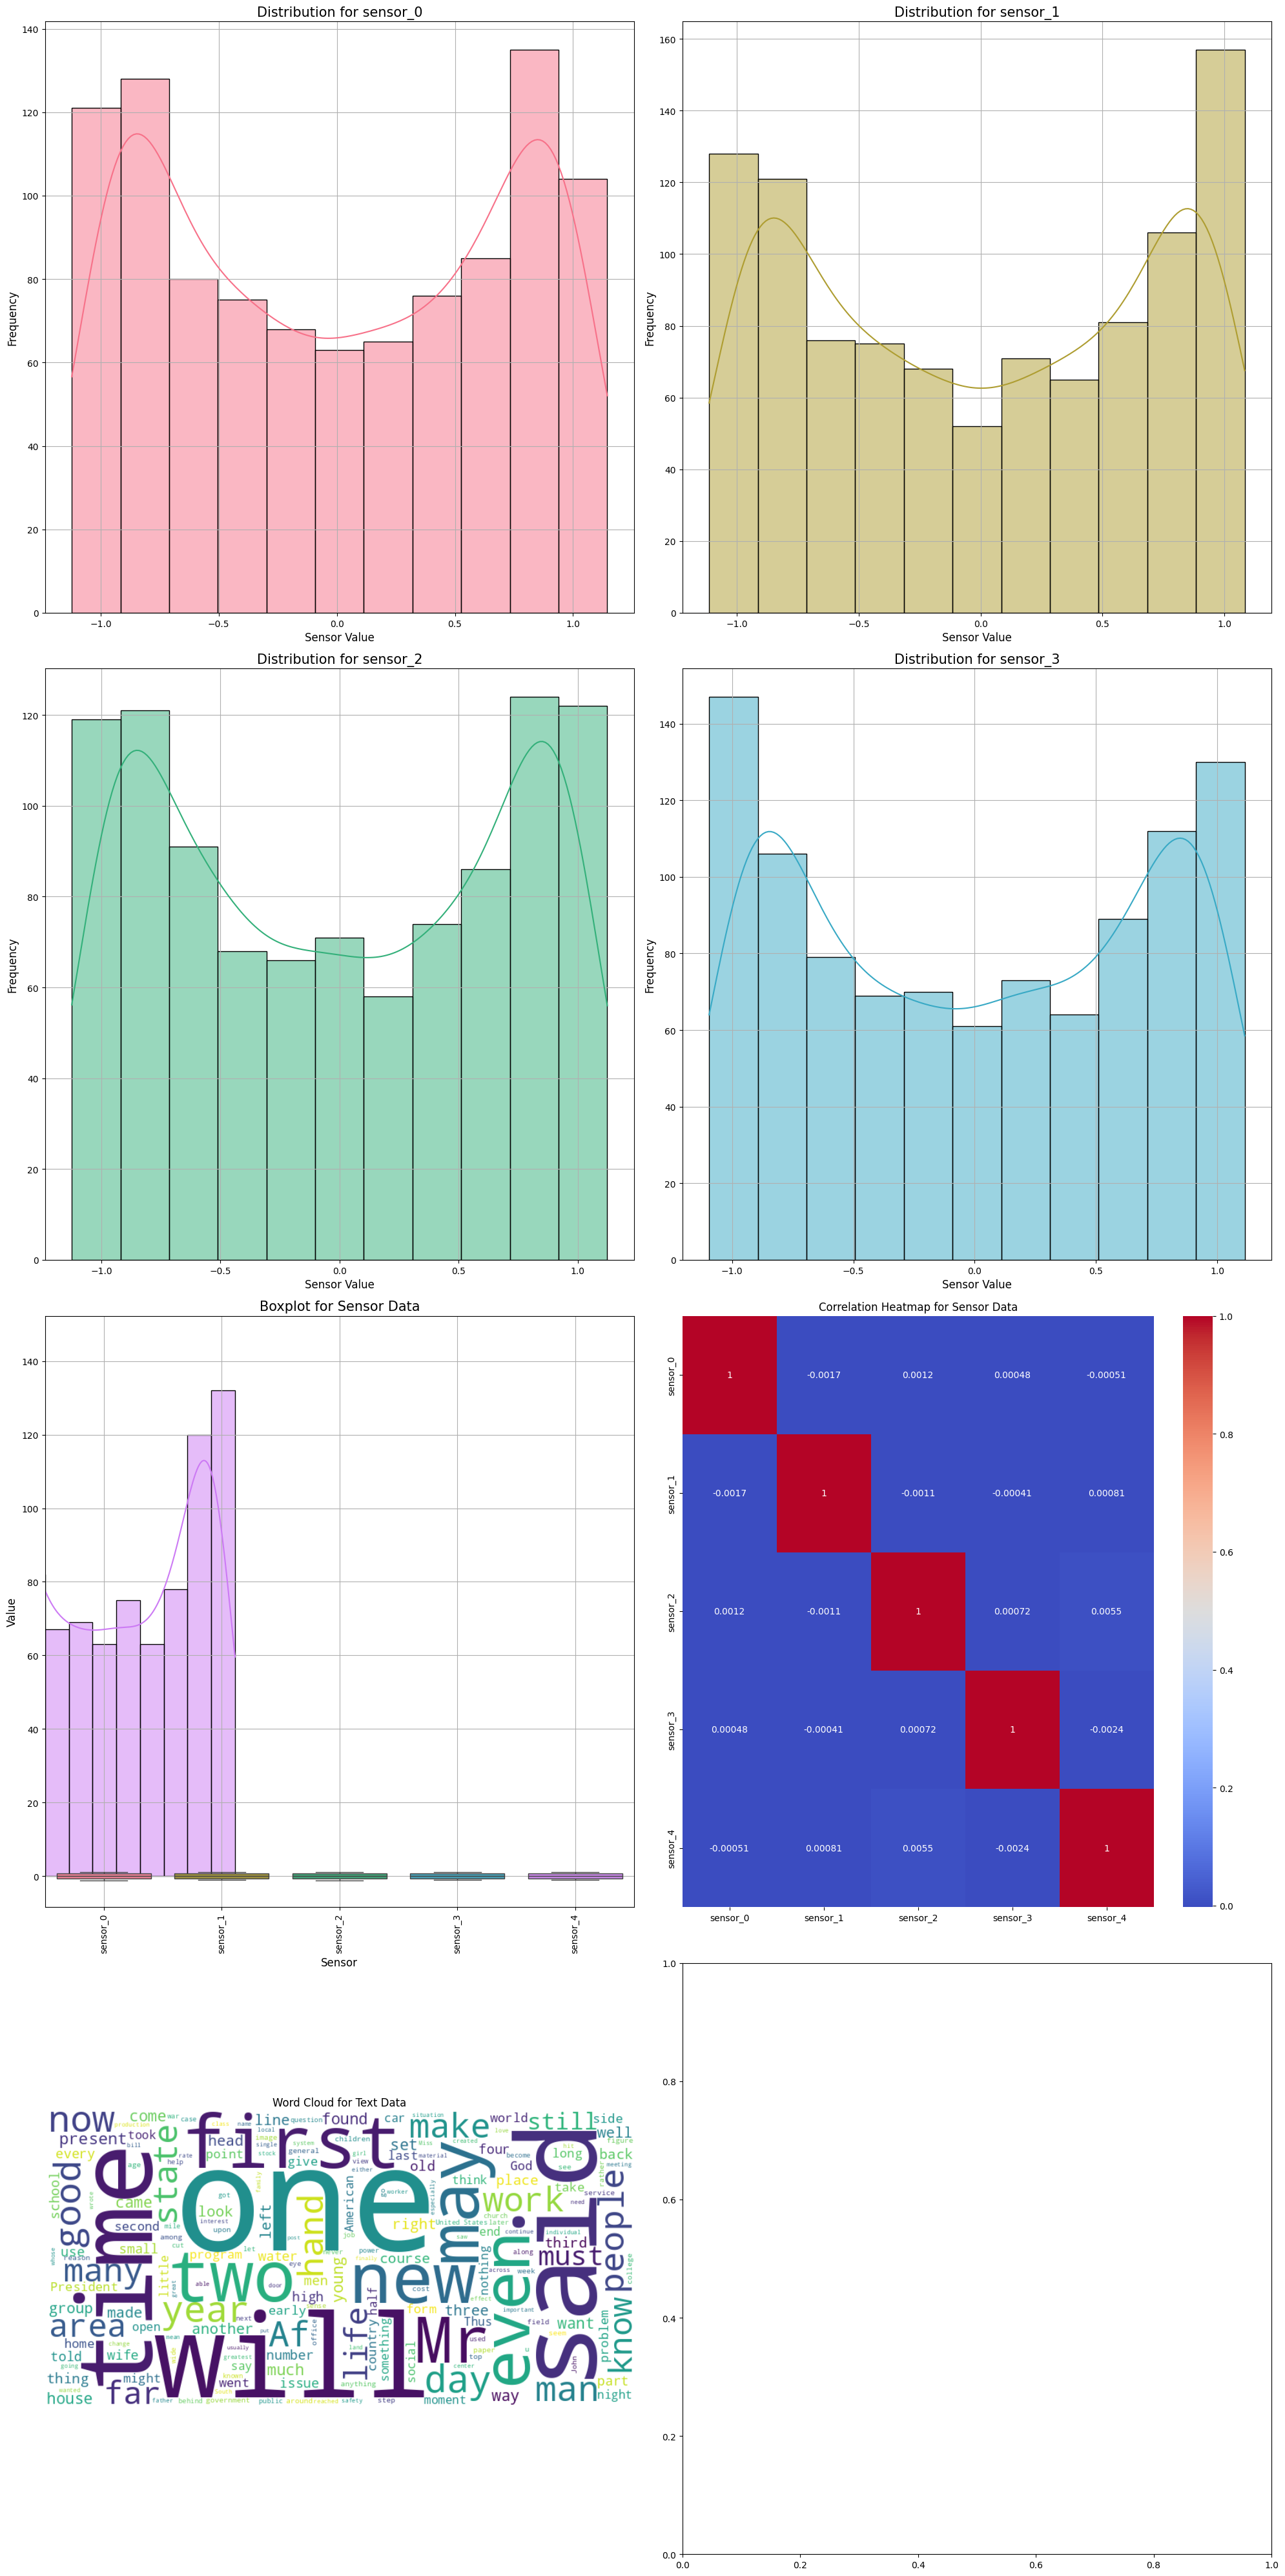

In [9]:
# Load the dataset
data = pd.read_csv('/content/SephsDataV3.csv')

# Visualization for Sensor Data
# Select only the first 5 sensor columns for demonstration
sensor_columns = [col for col in data.columns if 'sensor' in col][:5]
sensor_data = data[sensor_columns]

# Set a consistent color palette
palette = sns.color_palette("husl", len(sensor_columns))

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 40))  # Adjust the size as needed

# Histograms for each sensor
for i, sensor in enumerate(sensor_columns):
    ax = axes[i//2, i%2]  # Determine the position of the subplot
    sns.histplot(sensor_data[sensor], kde=True, color=palette[i], ax=ax)
    ax.set_title(f'Distribution for {sensor}', fontsize=15)
    ax.set_xlabel('Sensor Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True)

# Boxplot for sensor data
sns.boxplot(data=sensor_data, palette=palette, ax=axes[2, 0])
axes[2, 0].set_title('Boxplot for Sensor Data', fontsize=15)
axes[2, 0].tick_params(axis='x', rotation=90)
axes[2, 0].set_xlabel('Sensor', fontsize=12)
axes[2, 0].set_ylabel('Value', fontsize=12)
axes[2, 0].grid(True)

# Correlation Heatmap for sensor data
sns.heatmap(sensor_data.corr(), annot=True, cmap='coolwarm', ax=axes[2, 1])
axes[2, 1].set_title('Correlation Heatmap for Sensor Data')

# Visualization for NLP Data
text_data = data['text_data'].dropna()  # Drop NaN values if any

# Word Cloud for text data
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
axes[3, 0].imshow(wordcloud, interpolation='bilinear')
axes[3, 0].axis('off')
axes[3, 0].set_title('Word Cloud for Text Data')

# Adjust layout
plt.tight_layout()
plt.show()

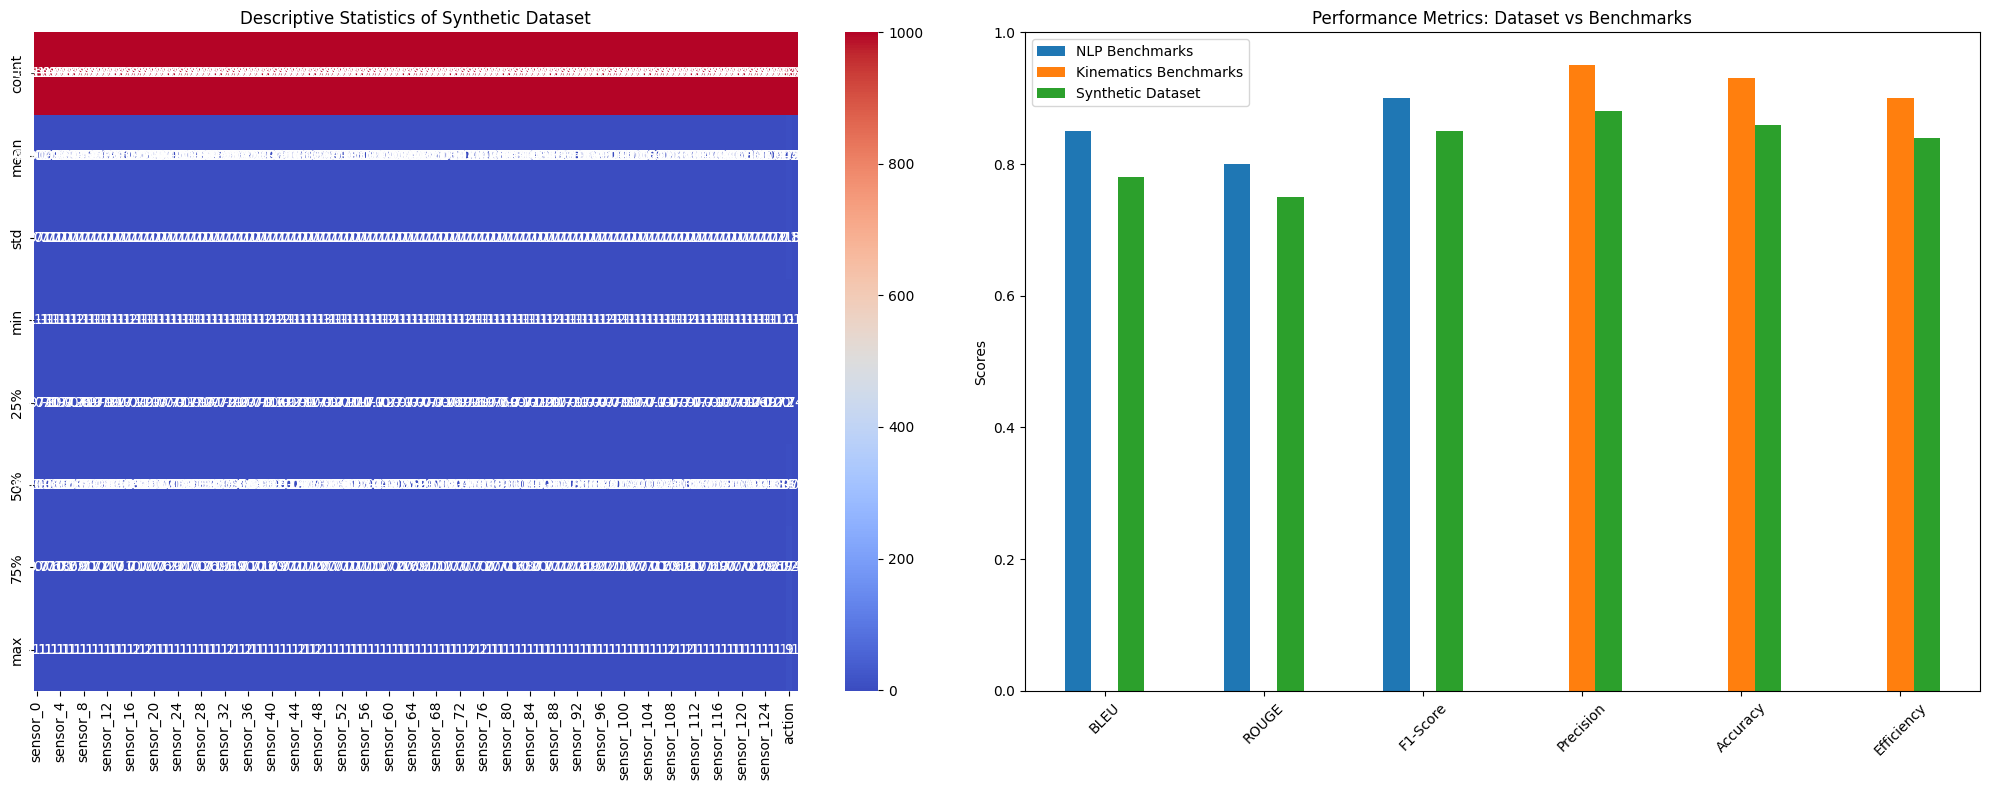

In [10]:
# Placeholder data for benchmarks (Replace with actual values from continuous research)
nlp_benchmarks = {'BLEU': 0.85, 'ROUGE': 0.80, 'F1-Score': 0.90}  # Example NLP benchmarks
kinematics_benchmarks = {'Precision': 0.95, 'Accuracy': 0.93, 'Efficiency': 0.90}  # Example kinematics benchmarks
your_dataset_metrics = {'BLEU': 0.78, 'ROUGE': 0.75, 'F1-Score': 0.85, 'Precision': 0.88, 'Accuracy': 0.86, 'Efficiency': 0.84}

# Convert to DataFrame for visualization
benchmark_df = pd.DataFrame([nlp_benchmarks, kinematics_benchmarks, your_dataset_metrics],
                            index=['NLP Benchmarks', 'Kinematics Benchmarks', 'Synthetic Dataset'])

# Descriptive statistics of the dataset
dataset_stats = df.describe()

# Visualization
plt.figure(figsize=(20, 8))

# Descriptive Statistics Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(dataset_stats, annot=True, cmap='coolwarm')
plt.title('Descriptive Statistics of Synthetic Dataset')

# Benchmark Comparison Bar Chart
plt.subplot(1, 2, 2)
benchmark_df.T.plot(kind='bar', ax=plt.gca())
plt.title('Performance Metrics: Dataset vs Benchmarks')
plt.ylabel('Scores')
plt.ylim(0, 1)  # Normalize score range
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()